# Setup notebook

In [ ]:
import os
import sys
from datetime import datetime

import numpy as np
import pandas as pd

import keras

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import RandomTranslation

import matplotlib.pyplot as plt

%matplotlib inline
seed = 76
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")
BATCH_SIZE = 64

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
tf.get_logger().setLevel('ERROR')
sys.stderr = open(os.devnull, 'w')

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


# Load data and augmentation

In [ ]:
training_data = np.load("/kaggle/input/datasetlomi/training_set_no_outliers.npz")
test_data = np.load("/kaggle/input/datasetlomi/test_set.npz")
images = training_data["images"]/255
labels = training_data["labels"]
print(images.shape)

(2270, 64, 128)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2)

In [ ]:
def add_channel(image, label):
    image = tf.cast(image, tf.float32)
    label = tf.cast(label, tf.float32)
    image = tf.expand_dims(image, axis=-1)
    label = tf.expand_dims(label, axis=-1)
    return image, label

In [ ]:
"Flip Left Right"
@tf.function
def random_flip_left_right(image, label, seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)

    flip_prob = tf.random.uniform([], seed=seed)

    image, label = tf.cond(
        flip_prob > 0.5,
        lambda: (tf.image.flip_left_right(image), tf.image.flip_left_right(label)),
        lambda: (image, label)
    )

    return image, label

In [ ]:
"Flip Up Down"
@tf.function
def random_flip_up_down(image, label, seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)

    flip_prob = tf.random.uniform([], seed=seed)

    image, label = tf.cond(
        flip_prob > 0.5,
        lambda: (tf.image.flip_up_down(image), tf.image.flip_up_down(label)),
        lambda: (image, label)
    )

    return image, label

In [ ]:
"Translation"
@tf.function
def translation(image, label, max_translation=0.2, seed=None):
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]

    max_dx = tf.cast(max_translation * tf.cast(width, tf.float32), tf.int32)
    max_dy = tf.cast(max_translation * tf.cast(height, tf.float32), tf.int32)

    dx = tf.random.uniform([], -max_dx, max_dx + 1, dtype=tf.int32, seed=seed)
    dy = tf.random.uniform([], -max_dy, max_dy + 1, dtype=tf.int32, seed=seed)

    translated_image = tf.roll(image, shift=[dy, dx], axis=[0, 1])
    translated_label = tf.roll(label, shift=[dy, dx], axis=[0, 1])

    return translated_image, translated_label


@tf.function
def random_translation(image, label, max_translation=0.2, seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)

    image, label = tf.cond(
        flip_prob > 0.7,
        lambda: (translation(image,label)),
        lambda: (image, label)
    )
    return image, label


In [ ]:
"zoom"
@tf.function
def zoom(image, label, zoom_range=(0.8, 1.2)):
    # Genera un fattore di zoom casuale
    zoom_factor = tf.random.uniform([], zoom_range[0], zoom_range[1])

    # Ottieni le dimensioni originali
    original_height = tf.shape(image)[0]
    original_width = tf.shape(image)[1]

    # Calcola le nuove dimensioni dopo lo zoom
    new_height = tf.cast(tf.cast(original_height, tf.float32) * zoom_factor, tf.int32)
    new_width = tf.cast(tf.cast(original_width, tf.float32) * zoom_factor, tf.int32)

    # Ridimensiona l'immagine e la maschera
    zoomed_image = tf.image.resize(image, [new_height, new_width], method='bilinear')
    zoomed_label = tf.image.resize(label, [new_height, new_width], method='bilinear')  # Per maschere, meglio 'nearest'

    # Ritaglia o pad per riportare alle dimensioni originali
    cropped_image = tf.image.resize_with_crop_or_pad(zoomed_image, original_height, original_width)
    cropped_label = tf.image.resize_with_crop_or_pad(zoomed_label, original_height, original_width)

    return cropped_image, cropped_label

@tf.function
def random_zoom(image, label, thr):
    prob = tf.random.uniform([])

    image, label = tf.cond(
        prob < thr,
        lambda: (zoom(image, label)),
        lambda: (image, label)
    )
    return image, label

def zoom_lambda(dataset, thr):
    return dataset.map(
        lambda x, y: random_zoom(x, y, thr),
        num_parallel_calls=tf.data.AUTOTUNE
    )


In [ ]:
"Black Square"
@tf.function
def random_black_square(image, label, max_square_ratio=0.2, seed=seed):
    # Calcola altezza e larghezza dell'immagine
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]

    # Determina la dimensione massima del quadrato, con un limite massimo di 32px
    max_square_size = tf.minimum(48, tf.cast(max_square_ratio * tf.minimum(tf.cast(height, tf.float32),
                                                                         tf.cast(width, tf.float32)), tf.int32))

    # Assicura che il quadrato abbia senso nelle dimensioni dell'immagine
    max_square_size = tf.maximum(15, tf.minimum(max_square_size, tf.minimum(height, width)))

    # Genera la dimensione del quadrato
    square_size = tf.random.uniform([], 1, max_square_size + 1, dtype=tf.int32, seed=seed)

    # Genera la posizione del quadrato
    max_x = tf.maximum(0, width - square_size)
    max_y = tf.maximum(0, height - square_size)

    start_x = tf.random.uniform([], 0, max_x + 1, dtype=tf.int32, seed=seed)
    start_y = tf.random.uniform([], 0, max_y + 1, dtype=tf.int32, seed=seed)

    # Crea una maschera per "cancellare" il quadrato
    mask = tf.ones_like(image)
    mask = tf.tensor_scatter_nd_update(
        mask,
        indices=tf.stack(tf.meshgrid(
            tf.range(start_y, start_y + square_size),
            tf.range(start_x, start_x + square_size)
        ), axis=-1),
        updates=tf.zeros([square_size, square_size, tf.shape(image)[-1]], dtype=image.dtype)
    )

    # Applica la maschera a immagine e label
    zeroed_image = image * mask
    zeroed_label = label * mask

    return zeroed_image, zeroed_label

@tf.function
def random_square(image, label, max_translation=0.2, seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)
    prob = tf.random.uniform([], seed=seed)

    image, label = tf.cond(
        prob > 0.7,
        lambda: random_black_square(image,label),
        lambda: (image, label)
    )
    return image, label


In [ ]:
"contrast"
@tf.function
def random_contrast(image, label, thr):
    prob = tf.random.uniform([], seed=seed)
    factor = tf.random.uniform([], minval=-4, maxval=4, seed=seed)


    image, label = tf.cond(
        prob < thr,
        lambda: (tf.image.adjust_contrast(image, factor), label),
        lambda: (image, label)
    )
    return image, label

def contrast_lambda(dataset, thr):
    return dataset.map(
        lambda x, y: random_contrast(x, y, thr),
        num_parallel_calls=tf.data.AUTOTUNE
    )

In [ ]:
"random_negative"
@tf.function
def random_negative(image, label, seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)

    image, label = tf.cond(
        flip_prob > 0.7,
        lambda: (1-image, label),
        lambda: (image, label)
    )

    return image, label

In [ ]:
def duplicate_dataset(images, labels, quantity = 1):
        images = np.concatenate([images, images[:quantity]], axis=0)
        labels = np.concatenate([labels, labels[:quantity]], axis=0)

        return (images, labels)


In [ ]:
def to_datasett(X_train, y_train, augmentation = False, seed = seed, shuffle = True, batch_size = BATCH_SIZE, duplicate = False):
    if duplicate:
        X_train, y_train = duplicate_dataset(X_train, y_train, len(X_train))
        X_train, y_train = duplicate_dataset(X_train, y_train, len(X_train))
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    dataset = dataset.map(
                    lambda x, y: add_channel(x, y),
                    num_parallel_calls=tf.data.AUTOTUNE
                   )

    if augmentation:
        dataset = dataset.map(
                        lambda x, y: random_flip_up_down(x,y,seed),
                        num_parallel_calls=tf.data.AUTOTUNE
                    )
        dataset = dataset.map(
                        lambda x, y: random_flip_left_right(x,y,seed),
                        num_parallel_calls=tf.data.AUTOTUNE
                    )
        dataset = dataset.map(
                        lambda x, y: random_translation(x,y,seed),
                        num_parallel_calls=tf.data.AUTOTUNE
                    )
        dataset = dataset.map(
                        lambda x, y: random_negative(x,y,seed),
                        num_parallel_calls=tf.data.AUTOTUNE
                    )
        dataset = dataset.map(
                        lambda x, y: random_square(x,y,seed),
                        num_parallel_calls=tf.data.AUTOTUNE
                    )

        dataset = zoom_lambda(dataset,0.7)

        dataset = contrast_lambda(dataset,0.7)

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
train_dataset = to_datasett(X_train, y_train, augmentation = True, duplicate = True)
val_dataset = to_datasett(X_val, y_val, augmentation = False, duplicate = True)

# Controlla train_dataset
print("Train Dataset Shapes:")
for image_batch, label_batch in train_dataset.take(1):  # Prendi un batch
    print("Batch immagini:", image_batch.shape)
    print("Batch etichette:", label_batch.shape)

# Controlla val_dataset
print("\nValidation Dataset Shapes:")
for image_batch, label_batch in val_dataset.take(1):  # Prendi un batch
    print("Batch immagini:", image_batch.shape)
    print("Batch etichette:", label_batch.shape)


Train Dataset Shapes:
Batch immagini: (64, 64, 128, 1)
Batch etichette: (64, 64, 128, 1)

Validation Dataset Shapes:
Batch immagini: (64, 64, 128, 1)
Batch etichette: (64, 64, 128, 1)


# Model

In [ ]:
from tensorflow.keras import layers

def double_convolution(x):
    # First 3x3 convolution: Reduces channels from 256 to 128
    x = layers.Conv2D(128, (3, 3), strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)  # Replace with ReLU if needed

    # Second 3x3 convolution: Keeps channels at 128
    x = layers.Conv2D(128, (3, 3), strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)  # Replace with ReLU if needed

    return x


In [ ]:
def convolutional_block(x, filters, kernel_size, strides=1):
    """A convolutional block with batch normalization and LeakyReLU activation."""
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)  # LeakyReLU activation
    return x

In [ ]:
def residual_block(x, filters, strides=1, use_projection=False):
    """A residual block for ResNet with LeakyReLU."""
    shortcut = x
    if use_projection:
        # Use a 1x1 conv layer to match dimensions if necessary
        shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding='same', kernel_initializer='he_normal')(x)
        shortcut = layers.BatchNormalization()(shortcut)

    # First convolution
    x = convolutional_block(x, filters, (3, 3), strides=strides)

    # Second convolution
    x = layers.Conv2D(filters, (3, 3), strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    # Add shortcut connection
    x = layers.Add()([x, shortcut])
    x = layers.LeakyReLU(alpha=0.1)(x)  # LeakyReLU activation
    return x

In [ ]:
def build_resnet50_with_filters(input_shape, filter_vector, num_classes=5):
    """
    Builds a modified ResNet-50 model with custom filters and a top-down pathway.

    Args:
        input_shape (tuple): Shape of the input tensor (e.g., (height, width, channels)).
        filter_vector (list): List of integers defining the number of filters for each stage.
        num_classes (int): Number of output classes for the final softmax layer.

    Returns:
        tf.keras.Model: A compiled ResNet-50-based model.
    """
    inputs = layers.Input(shape=input_shape)

    # Stage 1 (conv1): Initial convolutional block
    x = convolutional_block(inputs, filter_vector[0], (7, 7), strides=1)  # 7x7 Conv with custom filters
    c1 = layers.Conv2D(filter_vector[0], (3, 3), strides=1, padding='same', kernel_initializer='he_normal')(x)  # No downsampling
    print(c1.shape)  # Shape after first stage

    # Stage 2 (conv2): First set of residual blocks
    x = residual_block(c1, filter_vector[0], use_projection=True)
    x = residual_block(x, filter_vector[0])
    x = residual_block(x, filter_vector[0])
    c2 = x  # Save for the top-down pathway
    print(c2.shape)

    # Stage 3 (conv3): Second set of residual blocks with downsampling
    x = residual_block(c2, filter_vector[1], strides=2, use_projection=True)
    x = residual_block(x, filter_vector[1])
    x = residual_block(x, filter_vector[1])
    x = residual_block(x, filter_vector[1])
    c3 = x  # Save for the top-down pathway
    print(c3.shape)

    # Stage 4 (conv4): Third set of residual blocks with downsampling
    x = residual_block(c3, filter_vector[2], strides=2, use_projection=True)
    x = residual_block(x, filter_vector[2])
    x = residual_block(x, filter_vector[2])
    x = residual_block(x, filter_vector[2])
    x = residual_block(x, filter_vector[2])
    x = residual_block(x, filter_vector[2])
    c4 = x  # Save for the top-down pathway
    print(c4.shape)

    # Stage 5 (conv5): Final set of residual blocks with downsampling
    x = residual_block(c4, filter_vector[3], strides=2, use_projection=True)
    x = residual_block(x, filter_vector[3])
    x = residual_block(x, filter_vector[3])
    c5 = x  # Save for the top-down pathway
    print(c5.shape)

    # Top-Down Pathway with Dropout for Regularization
    print("PPPPP")
    p5 = layers.Conv2D(256, (1, 1), strides=1, padding="same", kernel_initializer='he_normal')(c5)  # Reduce depth
    p5 = layers.Dropout(0.3)(p5)  # Add dropout for regularization
    print(p5.shape)

    # Upsample and merge with previous stage (c4)
    down5 = layers.UpSampling2D(size=(2, 2), interpolation='nearest')(p5)
    p4 = layers.Add()([c4, down5])
    p4 = layers.Dropout(0.3)(p4)  # Dropout added
    print(p4.shape)

    # Repeat for additional stages in the top-down pathway
    down4 = layers.UpSampling2D(size=(2, 2), interpolation='nearest')(p4)
    c3 = layers.Conv2D(256, (1, 1), strides=1, padding="same", kernel_initializer='he_normal')(c3)
    p3 = layers.Add()([c3, down4])
    p3 = layers.Dropout(0.3)(p3)  # Dropout added
    print(p3.shape)

    down3 = layers.UpSampling2D(size=(2, 2), interpolation='nearest')(p3)
    c2 = layers.Conv2D(256, (1, 1), strides=1, padding="same", kernel_initializer='he_normal')(c2)
    p2 = layers.Add()([c2, down3])
    p2 = layers.Dropout(0.3)(p2)  # Dropout added
    print(p2.shape)

    down2 = p2
    c1 = layers.Conv2D(256, (1, 1), strides=1, padding="same", kernel_initializer='he_normal')(c1)
    p1 = layers.Add()([c1, down2])
    p1 = layers.Dropout(0.3)(p1)  # Dropout added
    print(p1.shape)

    # Final Convolutions and Upsampling
    conv5_3x3 = double_convolution(p5)
    conv4_3x3 = double_convolution(p4)
    conv3_3x3 = double_convolution(p3)
    conv2_3x3 = double_convolution(p2)
    conv1_3x3 = double_convolution(p1)

    conv5_upsampled = layers.Conv2DTranspose(128, (4, 4), strides=(8, 8), padding="same", kernel_initializer='he_normal')(conv5_3x3)
    conv4_upsampled = layers.Conv2DTranspose(128, (4, 4), strides=(4, 4), padding="same", kernel_initializer='he_normal')(conv4_3x3)
    conv3_upsampled = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same", kernel_initializer='he_normal')(conv3_3x3)
    conv2_upsampled = conv2_3x3  # No upsampling needed
    conv1_upsampled = conv1_3x3  # No upsampling needed

    print("Up5: ", conv5_upsampled.shape)
    print("Up4: ", conv4_upsampled.shape)
    print("Up3: ", conv3_upsampled.shape)
    print("Up2: ", conv2_upsampled.shape)
    print("Up1: ", conv1_upsampled.shape)

    # Concatenate all upsampled feature maps
    x = layers.Concatenate(axis=-1)([conv5_upsampled, conv4_upsampled, conv3_upsampled, conv2_upsampled, conv1_upsampled])
    print("Final concatenation: ", x.shape)

    # Final output layer with softmax activation for multi-class classification
    output_layer = layers.Conv2D(num_classes, kernel_size=1, activation="softmax", name="output_layer")(x)
    print("Output Shape: ", output_layer.shape)

    # Build and return the model
    model = tf.keras.Model(inputs=inputs, outputs=output_layer)

    return model


(None, 64, 128, 64)
(None, 64, 128, 64)
(None, 32, 64, 128)
(None, 16, 32, 256)
(None, 8, 16, 512)
PPPPP
(None, 8, 16, 256)
(None, 16, 32, 256)
(None, 32, 64, 256)
(None, 64, 128, 256)
(None, 64, 128, 256)
Up5:  (None, 64, 128, 128)
Up4:  (None, 64, 128, 128)
Up3:  (None, 64, 128, 128)
Up2:  (None, 64, 128, 128)
Up1:  (None, 64, 128, 128)
Final concatenation:  (None, 64, 128, 640)
Output Shape:  (None, 64, 128, 5)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 64, 128, │     3,200 │ input_layer[0… │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       256 │ conv2d[0][0]   │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ leaky_re_lu       │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│ (LeakyReLU)       │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_1 (Conv2D) │ (None, 64, 128, │    36,928 │ leaky_re_lu[0… │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_3 (Conv2D) │ (None, 64, 128, │    36,928 │ conv2d_1[0][0] │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       256 │ conv2d_3[0][0] │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ leaky_re_lu_1     │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│ (LeakyReLU)       │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_4 (Conv2D) │ (None, 64, 128, │    36,928 │ leaky_re_lu_1… │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_2 (Conv2D) │ (None, 64, 128, │     4,160 │ conv2d_1[0][0] │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       256 │ conv2d_4[0][0] │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       256 │ conv2d_2[0][0] │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add (Add)         │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 64)             │           │ batch_normali… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ leaky_re_lu_2     │ (None, 64, 128, │         0 │ add[0][0]      │   -   │
│ (LeakyReLU)       │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_5 (Conv2D) │ (None, 64, 128, │    36,928 │ leaky_re_lu_2… │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       256 │ conv2d_5[0][0] │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ leaky_re_lu_3     │ (None, 64, 128, │         0 │ batch_normali… │   - 

 Total params: 24,551,173 (93.66 MB)

 Trainable params: 24,531,461 (93.58 MB)

 Non-trainable params: 19,712 (77.00 KB)

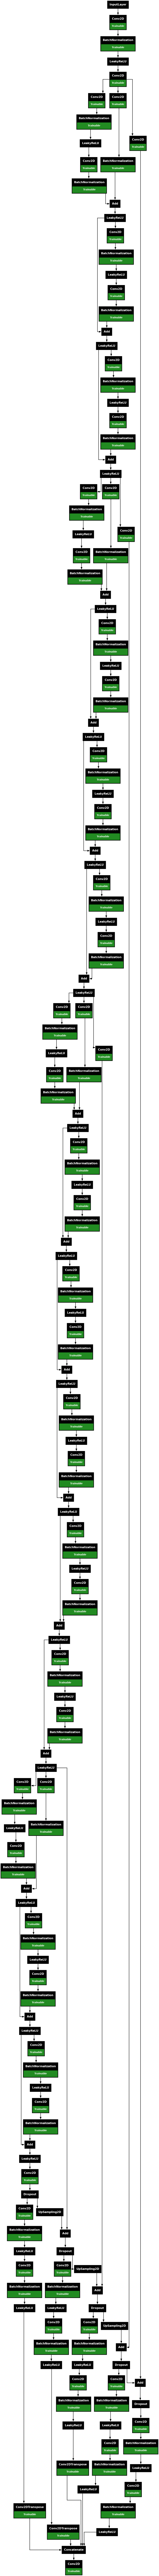

In [ ]:
input_shape = (64, 128, 1)
filter_vector = [64, 128, 256, 512]
batch_size=32
epochs = 1000
num_classes = 5
seed = 32
patience = 50

# Build and display the model
model = build_resnet50_with_filters(input_shape, filter_vector)
model.summary(expand_nested=True, show_trainable=True)
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

# Visualization

In [ ]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, frequency=5, num_classes=2):
        super().__init__()
        self.dataset = dataset
        self.frequency = frequency
        self.num_classes = num_classes
        self.dataset_iter = iter(dataset)  # Crea un iteratore per accedere ai dati

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualizza solo ogni "frequency" epochs
            try:
                # Estrai un batch di dati
                image, label = next(self.dataset_iter)
            except StopIteration:
                # Ricrea l'iteratore se i dati sono terminati
                self.dataset_iter = iter(self.dataset)
                image, label = next(self.dataset_iter)

            # Prepara i dati per la predizione
            image = tf.expand_dims(image[0], 0)  # Estrai una sola immagine dal batch
            label = label[0]  # Etichetta corrispondente
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Creazione della mappa colori
            colormap = create_segmentation_colormap(self.num_classes)

            plt.figure(figsize=(16, 4))

            # Immagine di input
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Predizione
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

viz_callback = VizCallback(val_dataset, frequency=5, num_classes=5)

# Losses

In [ ]:
import tensorflow as tf

class UnifiedFocalLoss:
    def __init__(self, lambda_=0.5, gamma_f=2.0, alpha_f=0.25, gamma_ft=1.0, alpha_ft=0.7, smooth=1e-7):
        """
        Inizializza la Unified Focal Loss.

        Args:
            lambda_ (float): Peso per la combinazione tra Focal Loss e Focal Tversky Loss.
            gamma_f (float): Esponente per il bilanciamento nella Focal Loss.
            alpha_f (float): Peso per le classi positive nella Focal Loss.
            gamma_ft (float): Esponente per il bilanciamento nella Focal Tversky Loss.
            alpha_ft (float): Peso per le classi positive nella Focal Tversky Loss.
            smooth (float): Termine di smoothing per evitare divisioni per zero.
        """
        self.lambda_ = lambda_
        self.gamma_f = gamma_f
        self.alpha_f = alpha_f
        self.gamma_ft = gamma_ft
        self.alpha_ft = alpha_ft
        self.smooth = smooth

    def focal_loss(self, y_true, y_pred):
        """
        Calcola la Focal Loss.

        Args:
            y_true (Tensor): Etichette vere.
            y_pred (Tensor): Predizioni del modello.

        Returns:
            Tensor: Valore della Focal Loss.
        """
        y_true = tf.cast(y_true, tf.float32)
        cross_entropy = -y_true * tf.math.log(y_pred + self.smooth)
        weight = tf.pow(1 - y_pred, self.gamma_f)
        focal_loss = self.alpha_f * weight * cross_entropy
        return tf.reduce_mean(focal_loss)

    def focal_tversky_loss(self, y_true, y_pred):
        """
        Calcola la Focal Tversky Loss.

        Args:
            y_true (Tensor): Etichette vere.
            y_pred (Tensor): Predizioni del modello.

        Returns:
            Tensor: Valore della Focal Tversky Loss.
        """
        y_true = tf.cast(y_true, tf.float32)
        intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
        false_negatives = tf.reduce_sum(y_true * (1 - y_pred), axis=[1, 2, 3])
        false_positives = tf.reduce_sum((1 - y_true) * y_pred, axis=[1, 2, 3])
        tversky_index = (intersection + self.smooth) / (
            intersection + self.alpha_ft * false_positives + (1 - self.alpha_ft) * false_negatives + self.smooth
        )
        focal_tversky_loss = tf.pow(1 - tversky_index, self.gamma_ft)
        return tf.reduce_mean(focal_tversky_loss)

    def __call__(self, y_true, y_pred):
        """
        Calcola la Unified Focal Loss.

        Args:
            y_true (Tensor): Etichette vere.
            y_pred (Tensor): Predizioni del modello.

        Returns:
            Tensor: Valore della Unified Focal Loss.
        """
        lf = self.focal_loss(y_true, y_pred)
        lft = self.focal_tversky_loss(y_true, y_pred)
        return self.lambda_ * lf + (1 - self.lambda_) * lft

    def get_config(self):
        """
        Restituisce la configurazione per la serializzazione.

        Returns:
            dict: Configurazione della loss.
        """
        return {
            "lambda_": self.lambda_,
            "gamma_f": self.gamma_f,
            "alpha_f": self.alpha_f,
            "gamma_ft": self.gamma_ft,
            "alpha_ft": self.alpha_ft,
            "smooth": self.smooth,
        }

    @classmethod
    def from_config(cls, config):
        """
        Crea un'istanza della classe dalla configurazione.

        Args:
            config (dict): Configurazione della loss.

        Returns:
            UnifiedFocalLoss: Nuova istanza della classe.
        """
        return cls(**config)

unifiedFocalLoss = UnifiedFocalLoss(lambda_=0.7, gamma_f=2.0, alpha_f=0.25, gamma_ft=1.0, alpha_ft=0.7)


In [ ]:
from tensorflow.keras import backend as K

def iou_loss(y_true, y_pred, smooth=1e-7):
    if y_true.shape[-1] != y_pred.shape[-1]:
        y_true = tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=tf.shape(y_pred)[-1])

    # Calcolo di Intersection e Union
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2]) - intersection
    iou = (intersection + smooth) / (union + smooth)

    # Loss come complemento dell'IoU
    return 1 - tf.reduce_mean(iou)


In [ ]:
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=[0], name="mean_iou", dtype=None, **kwargs):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        return super().update_state(y_true, y_pred, sample_weight)

# Registra la classe personalizzata
tf.keras.utils.get_custom_objects()["MeanIntersectionOverUnion"] = MeanIntersectionOverUnion


In [ ]:
labels_flat = y_train.reshape(-1)  # Appiattisci l'array per considerare tutti i pixel

# Conta la frequenza di ogni classe
num_classes = 5  # Modifica in base al numero di classi nel tuo dataset
labels_flat = labels_flat.astype(int)  # Converte i dati in interi

# Conta la frequenza di ogni classe
class_frequencies = np.bincount(labels_flat, minlength=num_classes)

# Stampa le frequenze
print(f"Frequenze delle classi: {class_frequencies}")

total_samples = np.sum(class_frequencies)
class_weights = total_samples / (len(class_frequencies) * class_frequencies)
print(f"Pesi di classe: {class_weights}")

# Conversione in dizionario per TensorFlow
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Funzione di perdita con pesi di classe
loss = tf.keras.losses.SparseCategoricalCrossentropy()


def weighted_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int32)  # Assicurati che i valori siano interi
    weights = tf.gather(class_weights, y_true)  # Recupera i pesi in base alle etichette
    weights = tf.cast(weights, tf.float32)  # Converte i pesi in float32
    unweighted_loss = loss(y_true, y_pred)
    weighted_loss = unweighted_loss * weights
    return tf.reduce_mean(weighted_loss)

Frequenze delle classi: [4031901 4024896 3759246 3041292   19337]
Pesi di classe: [  0.73794828   0.73923262   0.79147106   0.97831264 153.86742514]


In [ ]:
class ComboLoss:
    def __init__(self, alpha=0.5, dice_smooth=1e-7, class_weights=None):
        self.alpha = alpha
        self.dice_smooth = dice_smooth
        self.class_weights = class_weights

    def dice_loss(self, y_true, y_pred):
        y_true = tf.cast(tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=y_pred.shape[-1]), tf.float32)
        intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
        cardinality = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])
        dice = (2. * intersection + self.dice_smooth) / (cardinality + self.dice_smooth)
        return 1 - tf.reduce_mean(dice)

    def weighted_loss(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)  # Assicurati che i valori siano interi
        weights = tf.gather(class_weights, y_true)  # Recupera i pesi in base alle etichette
        weights = tf.cast(weights, tf.float32)  # Converte i pesi in float32
        unweighted_loss = loss(y_true, y_pred)
        weighted_loss = unweighted_loss * weights
        return tf.reduce_mean(weighted_loss)

    def __call__(self, y_true, y_pred):
        wce = self.weighted_loss(y_true, y_pred)
        dice = self.dice_loss(y_true, y_pred)
        return self.alpha * wce + (1 - self.alpha) * dice

    def get_config(self):
        return {
            "alpha": self.alpha,
            "dice_smooth": self.dice_smooth,
            "class_weights": self.class_weights
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)


combo_loss = ComboLoss(alpha=0.6, class_weights=class_weights)

In [ ]:
class CombinedLoss:
    def __init__(self, jaccard_smooth=1e-7, jaccard_weight=0.5, cross_entropy_weight=0.5):
        self.jaccard_smooth = jaccard_smooth
        self.jaccard_weight = jaccard_weight
        self.cross_entropy_weight = cross_entropy_weight

    def jaccard_loss(self, y_true, y_pred):
        y_true = tf.cast(tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=y_pred.shape[-1]), tf.float32)
        intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
        union = tf.reduce_sum(y_true + y_pred, axis=[1, 2]) - intersection
        jaccard = (intersection + self.jaccard_smooth) / (union + self.jaccard_smooth)
        return 1 - tf.reduce_mean(jaccard)

    def cross_entropy_loss(self, y_true, y_pred):
        return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred))

    def __call__(self, y_true, y_pred):
        jaccard = self.jaccard_loss(y_true, y_pred)
        cross_entropy = self.cross_entropy_loss(y_true, y_pred)
        return self.jaccard_weight * jaccard + self.cross_entropy_weight * cross_entropy

    def get_config(self):
        return {
            "jaccard_smooth": self.jaccard_smooth,
            "jaccard_weight": self.jaccard_weight,
            "cross_entropy_weight": self.cross_entropy_weight,
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

combined_loss = CombinedLoss(
    jaccard_smooth=1e-6,
    jaccard_weight=0.7,
    cross_entropy_weight=0.3
)

In [ ]:
def combined_loss2(y_true, y_pred, wce_weight=0.5, iou_weight=0.5):
    # Weighted Cross-Entropy Loss
    wce = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred))

    # IoU Loss
    y_true_one_hot = tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=tf.shape(y_pred)[-1])
    intersection = tf.reduce_sum(y_true_one_hot * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true_one_hot + y_pred, axis=[1, 2]) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    iou_loss = 1 - tf.reduce_mean(iou)

    # Perdita combinata
    loss = wce_weight * wce + iou_weight * iou_loss
    return loss


# Compilation and training

In [ ]:
model.compile(
        loss=combined_loss2,
        optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
        metrics=[
            "accuracy",
            MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])
        ]
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Definisci il percorso di salvataggio nella directory di lavoro
model.save("/kaggle/working/PAM20_combine.keras")

# Delete the model to free up resources
del model

Epoch 1/1000
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3330 - loss: 1.1695 - mean_iou: 0.1006   

# Testing and saving

In [ ]:
model_filename = "PAM20_combine.keras"

X_test = np.load("/kaggle/input/datasetlomi/test_set.npz")
model = tf.keras.models.load_model(
    "/kaggle/working/PAM20_combine.keras",
    custom_objects={'ComboLoss': ComboLoss}
)

preds = model.predict(X_test["images"]/255)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)